In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random 
from pyvis.network import Network
import time
import itertools

In [3]:
adj_matrix = np.zeros((100, 100))
possible_edges = [(i, j) for i in range(100) for j in range(100) if i < j ]
random.seed(42)
for k in random.sample(possible_edges, 500):
    w = np.random.randint(1, 100)
    adj_matrix[k[0]][k[1]], adj_matrix[k[1]][k[0]] = w, w

In [4]:
G = nx.from_numpy_matrix(adj_matrix)

In [5]:
def adjacency_list(G):
    return {i[0]: tuple(i[1].keys()) for i in G.adjacency()}

adj_list = adjacency_list(G)

In [6]:
nt = Network("700px", "700px", notebook=True, bgcolor="#222222", font_color="#FFFFFF", 
             heading='Undirected weighted graph')
nt.from_nx(G)
nt.toggle_physics(False)
nt.show("nx.html")

In [7]:
#Dijkstra's algorithm
length_D, path_D = nx.single_source_dijkstra(G, 0)

In [8]:
#Bellman-Ford algorithm
length_BF, path_BF = nx.single_source_bellman_ford(G, 0)

In [9]:
def time_meas(method, *args, nit=10):
    timings = []
    for i in range(nit):
        st = time.time()
        res = method(*args)
        timings.append(time.time() - st)
    return np.mean(timings)

In [10]:
for i in range(10):
    bf = time_meas(nx.single_source_bellman_ford, G, 0)
    d = time_meas(nx.single_source_dijkstra, G, 0)
    print(bf/d, bf, d)

2.6638336022951408 0.0017709970474243165 0.000664830207824707
2.972389914772727 0.0015964984893798828 0.000537109375
2.50657156955098 0.001332259178161621 0.0005315065383911133
2.5439836339966524 0.0013045310974121095 0.0005127906799316407
2.542351629980496 0.0013052701950073242 0.0005134105682373047
1.4313831816995037 0.001699209213256836 0.00118710994720459
3.0251877568371826 0.002035975456237793 0.0006730079650878907
2.600904392764858 0.0014398813247680664 0.0005536079406738281
2.434214605199061 0.0013105154037475586 0.0005383729934692383
2.532400365074536 0.0013892173767089844 0.0005485773086547852


## A*

In [22]:
grid = np.array([[1]*10]*10)
random.seed(40)
for i, j in random.sample(list([i, j] for i in range(10) for j in range(10)), 30):
    grid[i][j] = 0

In [23]:
grid

array([[1, 1, 1, 0, 0, 1, 0, 0, 1, 1],
       [1, 1, 1, 1, 0, 1, 0, 1, 0, 1],
       [1, 1, 0, 1, 1, 0, 0, 1, 1, 1],
       [1, 0, 0, 1, 1, 0, 0, 1, 1, 1],
       [0, 0, 1, 1, 0, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 1, 0, 1],
       [1, 1, 1, 1, 1, 0, 0, 0, 1, 1],
       [1, 1, 1, 1, 0, 1, 1, 1, 1, 0],
       [1, 0, 1, 1, 1, 0, 1, 1, 1, 0],
       [1, 1, 1, 0, 1, 1, 1, 0, 1, 0]])

In [24]:
zeros = tuple(zip(*np.where(grid == 0)))

In [25]:
G1 = nx.grid_graph(dim=[10, 10])

In [26]:
def weights_setting_von_neumman(G):
    for key in dict(G.adjacency()):
        for node in list(dict(G.adjacency())[key].keys()):
            G[key][node]['weight'] = 1.0

In [27]:
weights_setting_von_neumman(G1)

In [38]:
# Adding the diagonal neighbors
def adding_edges(G):
    def neighbours_moore(node):
        x = node[0]
        y = node[1]
        neighbours = ((x-1, y-1), (x+1, y+1), (x-1, y+1), (x+1, y-1))
        return list(t for t in neighbours if (0 <= t[0] <= 9)  and (0 <= t[1] <= 9))
    add_neighbours = []
    for key in dict(G.adjacency()).keys():
        for neighbour in neighbours_moore(key):
            add_neighbours.append((key, neighbour))
    return add_neighbours

In [39]:
# And setting the weights respectively
G1.add_edges_from(adding_edges(G1), weight=np.sqrt(2))

In [40]:
# Obstacles 
def delete_zeros(G, grid):
    ad = dict(G.adjacency())
    for k in ad.keys():
        for zero in tuple(zip(*np.where(grid == 0))):
            if zero in ad[k].keys():
                ad[k].pop(zero)
    for k in zeros:
        ad.pop(k)
    return nx.Graph(ad)

In [41]:
G2 = delete_zeros(G1, grid)

In [30]:
def manhattan(a, b):
    (x1, y1) = a
    (x2, y2) = b
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    return (dx + dy)

def chebyshev(a, b):
    (x1, y1) = a
    (x2, y2) = b
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    return (dx + dy) - min(dx, dy)

# nenad
def octile(a, b):
    (x1, y1) = a
    (x2, y2) = b
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    return (dx + dy) + (np.sqrt(2) - 2) * min(dx, dy)

def euclidian(a, b):
    (x1, y1) = a
    (x2, y2) = b
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    return np.sqrt(dx * dx + dy * dy)


res_m = nx.astar_path(G2, (0, 0), (9, 8), heuristic=manhattan)
res_ch = nx.astar_path(G2, (0, 0), (9, 8), heuristic=chebyshev)
res_oc = nx.astar_path(G2, (0, 0), (9, 8), heuristic=octile)
res_euc = nx.astar_path(G2, (0, 0), (9, 8), heuristic=euclidian)

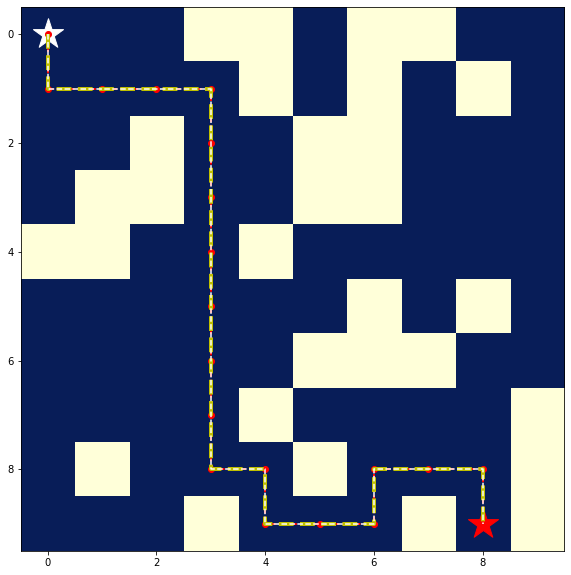

In [31]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(grid, cmap=plt.cm.YlGnBu)
ax.scatter(0, 0, marker = "*", color = "w", s = 1000)
ax.scatter(8, 9, marker = "*", color = "r", s = 1000)
#plt.plot(tuple(zip(*res_sq))[1], tuple(zip(*res_sq))[0], color='g', marker='o', linewidth=5)
plt.plot(tuple(zip(*res_m))[1], tuple(zip(*res_m))[0], color='r', 
         marker='o', linestyle='dashed', linewidth=2)
plt.plot(tuple(zip(*res_ch))[1], tuple(zip(*res_ch))[0], color='y', 
        linestyle='dashed', linewidth=4)
#plt.plot(tuple(zip(*res_oc))[1], tuple(zip(*res_oc))[0], color='b', marker='o', linestyle='dashed')
plt.plot(tuple(zip(*res_euc))[1], tuple(zip(*res_euc))[0], color='#FFFFFF', 
         linestyle='dashed')
plt.show()

In [32]:
for i in range(1000):
    random.seed(545)
    try:
        res_sq1 = nx.astar_path(G2, (np.random.randint(0, 10), np.random.randint(0, 10)), 
                       (np.random.randint(0, 10), np.random.randint(0, 10)), 
                       heuristic=squared)
        res_sq2 = nx.astar_path(G2, (np.random.randint(0, 10), np.random.randint(0, 10)), 
                       (np.random.randint(0, 10), np.random.randint(0, 10)), 
                       heuristic=squared)
        res_sq3 = nx.astar_path(G2, (np.random.randint(0, 10), np.random.randint(0, 10)), 
                       (np.random.randint(0, 10), np.random.randint(0, 10)), 
                       heuristic=squared)
        res_sq4 = nx.astar_path(G2, (np.random.randint(0, 10), np.random.randint(0, 10)), 
                       (np.random.randint(0, 10), np.random.randint(0, 10)), 
                       heuristic=squared)
        res_sq5 = nx.astar_path(G2, (np.random.randint(0, 10), np.random.randint(0, 10)), 
                       (np.random.randint(0, 10), np.random.randint(0, 10)), 
                       heuristic=squared)
        print(i)
    except:
        pass

16
254
267
295
310
336
344
349
470
484
486
573
639
710
721
729
755
805
834
846


In [33]:
def plot(results, start=0, end=0, title=''):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(grid, cmap=plt.cm.YlGnBu)
    if start != 0:
        ax.scatter(start[1], start[0], marker = "*", color = "w", s = 1000)
        ax.scatter(end[1], end[0], marker = "*", color = "r", s = 1000)
    plt.plot(tuple(zip(*results[0]))[1], tuple(zip(*results[0]))[0], color='g', 
         marker='o', linewidth=5)
    plt.plot(tuple(zip(*results[1]))[1], tuple(zip(*results[1]))[0], color='r', 
         marker='o', linestyle='dashed', linewidth=2)
    plt.plot(tuple(zip(*results[2]))[1], tuple(zip(*results[2]))[0], color='y', 
        linestyle='dashed', linewidth=4)
    plt.plot(tuple(zip(*results[3]))[1], tuple(zip(*results[3]))[0], color='b', 
         marker='o', linestyle='dashed')
    plt.plot(tuple(zip(*results[4]))[1], tuple(zip(*results[4]))[0], color='#FFFFFF', 
         linestyle='dashed')
    plt.title(title)
    return plt.show()

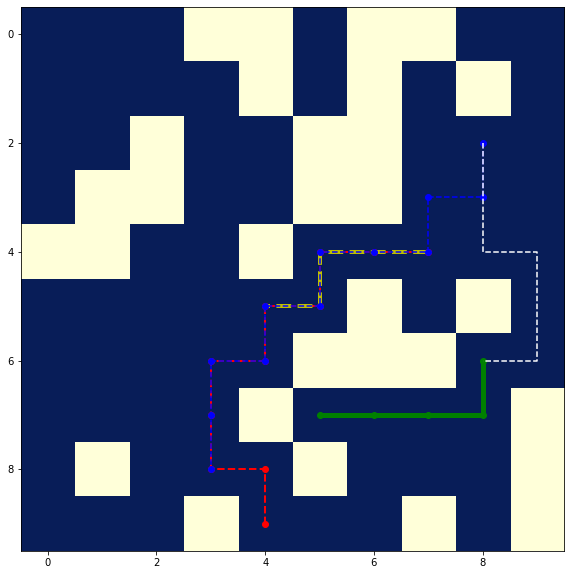

In [34]:
plot([res_sq1, res_sq2, res_sq3, res_sq4, res_sq5])

In [43]:
for i in range(1000):
    random.seed(545)
    try:
        x1one, x1two, x1three, x1four, x1five = np.random.randint(0, 10, size=5)
        y1one, y1two, y1three, y1four, y1five = np.random.randint(0, 10, size=5)
        x2one, x2two, x2three, x2four, x2five = np.random.randint(0, 10, size=5)
        y2one, y2two, y2three, y2four, y2five = np.random.randint(0, 10, size=5)
        res_e1 = nx.astar_path(G2, (x1one, y1one), (x2one, y2one), heuristic=euclidian)
        res_m1 = nx.astar_path(G2, (x1one, y1one), (x2one, y2one), heuristic=manhattan)
        res_e2 = nx.astar_path(G2, (x1two, y1two), (x2two, y2two), heuristic=euclidian)
        res_m2 = nx.astar_path(G2, (x1two, y1two), (x2two, y2two), heuristic=manhattan)
        res_e3 = nx.astar_path(G2, (x1three, y1three), (x2three, y2three), heuristic=euclidian)
        res_m3 = nx.astar_path(G2, (x1three, y1three), (x2three, y2three), heuristic=manhattan)
        res_e4 = nx.astar_path(G2, (x1four, y1four), (x2four, y2four), heuristic=euclidian)
        res_m4 = nx.astar_path(G2, (x1four, y1four), (x2four, y2four), heuristic=manhattan)
        res_e5 = nx.astar_path(G2, (x1five, y1five), (x2five, y2five), heuristic=euclidian)
        res_m5 = nx.astar_path(G2, (x1five, y1five), (x2five, y2five), heuristic=manhattan)
        
        print(i)
    except:
        pass

2
56
81
136
218
238
252
279
353
373
386
391
497
545
586
595
626
635
679
730
770
783
796
798
811
820
830
885
971
996


In [44]:
for i in range(1000):
    random.seed(545)
    try:
        x1one, x1two, x1three, x1four, x1five = np.random.randint(0, 10, size=5)
        y1one, y1two, y1three, y1four, y1five = np.random.randint(0, 10, size=5)
        x2one, x2two, x2three, x2four, x2five = np.random.randint(0, 10, size=5)
        y2one, y2two, y2three, y2four, y2five = np.random.randint(0, 10, size=5)
        res_e1 = nx.astar_path(G2, (x1one, y1one), (x2one, y2one), heuristic=euclidian)
        res_m1 = nx.astar_path(G2, (x1one, y1one), (x2one, y2one), heuristic=chebyshev)
        res_e2 = nx.astar_path(G2, (x1two, y1two), (x2two, y2two), heuristic=euclidian)
        res_m2 = nx.astar_path(G2, (x1two, y1two), (x2two, y2two), heuristic=chebyshev)
        res_e3 = nx.astar_path(G2, (x1three, y1three), (x2three, y2three), heuristic=euclidian)
        res_m3 = nx.astar_path(G2, (x1three, y1three), (x2three, y2three), heuristic=chebyshev)
        res_e4 = nx.astar_path(G2, (x1four, y1four), (x2four, y2four), heuristic=euclidian)
        res_m4 = nx.astar_path(G2, (x1four, y1four), (x2four, y2four), heuristic=chebyshev)
        res_e5 = nx.astar_path(G2, (x1five, y1five), (x2five, y2five), heuristic=euclidian)
        res_m5 = nx.astar_path(G2, (x1five, y1five), (x2five, y2five), heuristic=chebyshev)
        
        print(i)
    except:
        pass

51
128
142
143
186
216
306
329
371
436
525
579
598
610
613
620
756
775
780
861
867
883
916
921
923
954


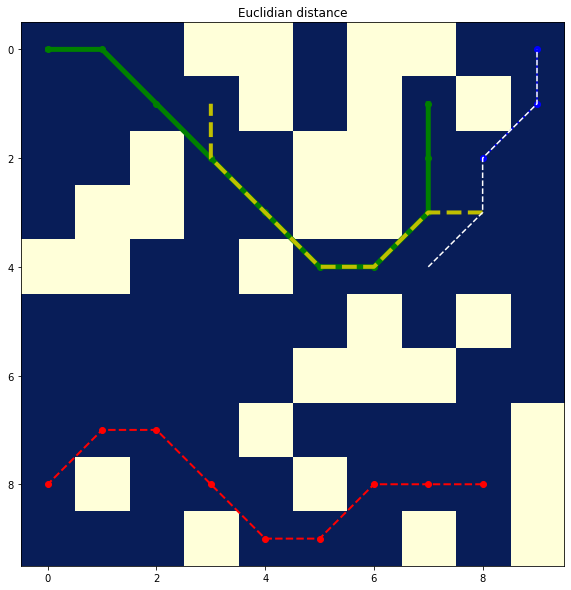

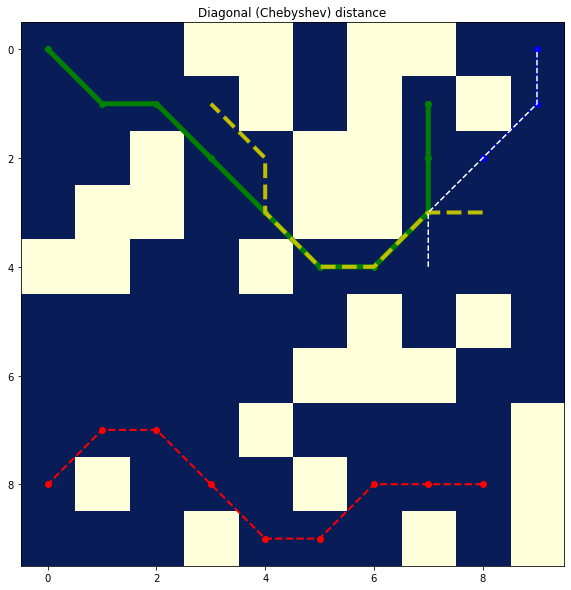

In [45]:
plot([res_e1, res_e2, res_e3, res_e4, res_e5], title='Euclidian distance')

plot([res_m1, res_m2, res_m3, res_m4, res_m5], title='Diagonal (Chebyshev) distance')


In [103]:
def distance(result, dist_function=euclidian):
    s = 0
    for i in range(1, len(result[1:])):
        s += dist_function(result[i-1], result[i])
    return s      